### Modelos
- Modelo Óbito-Curado (60/40): Regressão
- Modelo Internado-Curado (70/30): AdaBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import modelofuncoes as mf

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

importing Jupyter notebook from modelofuncoes.ipynb


### Modelo OC - Constatando o Desempenho

In [2]:
# Carregando a Base de Dados

url = 'Vacinas/OC/oc-vacina-6040-sp.xlsx'
alvo = 'evolucaoCaso'
baseObitoCurado = pd.read_excel(url)

bases = {}
bases['Base OC (60/40)'] = url

In [3]:
baseObitoCurado[alvo].value_counts()

1    4080
0    1632
Name: evolucaoCaso, dtype: int64

In [4]:
# Definindo o Modelo de Regressão Logística
hiperparametrosLR = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, 
                                       intercept_scaling=1, l1_ratio=None, max_iter=1000, multi_class='auto', 
                                       n_jobs=None, penalty='l2', random_state=1340, solver='lbfgs', 
                                       tol=0.0001, verbose=0, warm_start=False)

modeloClassificador = {"LR": hiperparametrosLR}

In [5]:
valoresAlvo = [0, 1]

colunasRemovidas = ['dataPrimeiraDose', 'dataSegundaDose', 'assintomatico', 'puerpera', 'disturbiosGustatorios', 
                    'disturbiosOlfativos', 'gestante', 'tosse', 'respiratoria', 'fragilidadeImuno', 'racaCor', 
                    'sexo', 'febre', 'renal', 'imunossupressao', 'obesidade']

desempenhoDosModelos = mf.testarModelos(bases, alvo, colunasRemovidas, modeloClassificador, valoresAlvo)
desempenhoDosModelos

Index(['evolucaoCaso', 'dorDeGarganta', 'dispneia', 'coriza', 'dorDeCabeca',
       'diabetes', 'cardiaca', 'faixaetaria', 'qntVacinas'],
      dtype='object')


,Base,Modelo,Hiperparâmetros,Acurácia,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1),3 Kfolds,5 Kfolds
0,Base OC (60/40),LR,"{'C': 1.0, 'class_weight': None, 'dual': False...",83.372%,84.181%,56.546%,67.65%,83.162%,95.282%,88.81%,83.473%,83.806%


### Definindo a Função da Curva ROC

In [6]:
def exibirCurvaROC(modeloClassificador, x_test, y_test):
    y_preds = modeloClassificador.predict_proba(x_test)

    # take the second column because the classifier outputs scores for the 0 class as well
    preds = y_preds[:,1]

    # fpr (false-positive-rate) e tpr (true-positive-rate)
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    auc_score = metrics.auc(fpr, tpr)

    # Construindo o Gráfico
    plt.clf()
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
    plt.plot([0,1],[0,1],'r--')

    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.legend(loc='lower right')
    plt.show()

### Modelo OC - Treinamento e Teste

In [7]:
# Carregando a Base de Dados
baseObitoCurado = pd.read_excel(url)

In [8]:
# Selecionando os Atributos do Pré-Processamento

atributosSelecionados = ['faixaetaria', 'dispneia', 'qntVacinas', 'dorDeGarganta', 
                         'coriza', 'diabetes', 'dorDeCabeca', 'cardiaca', 'evolucaoCaso']

baseObitoCurado = baseObitoCurado.loc[:, atributosSelecionados]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(baseObitoCurado.drop(alvo,axis=1),
                                                    baseObitoCurado[alvo],
                                                    test_size=0.3,
                                                    random_state=42);

In [10]:
# Fit nos dados
modeloClassificador = hiperparametrosLR
modeloClassificador.fit(x_train, y_train)

#Realizando a predição
resultadoTeste = modeloClassificador.predict(x_test)

# Verificando a acurácia
print(metrics.classification_report(y_test,resultadoTeste))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68       527
           1       0.83      0.95      0.89      1187

    accuracy                           0.83      1714
   macro avg       0.84      0.76      0.78      1714
weighted avg       0.83      0.83      0.82      1714



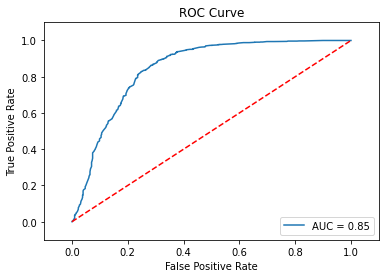

In [11]:
# Plotando a curva ROC
exibirCurvaROC(modeloClassificador, x_test, y_test)

In [12]:
# Exportando o modelo criado
# dump(modeloClassificador, 'modeloOC.pk1')

### Funções Utilizadas

In [12]:
def __transformarEmPorcentagem__(valor):
    porcentagem = str(round(valor * 100, 3)) + "%"
    return porcentagem

In [13]:
def calcularMetricas(x_test, y_test, baseDeDados, classificador, alvos):
    metricas = {}
    
    #Realizando a predição
    resultadoPredicao = classificador.predict(x_test)

    # Verificando a acurácia
    metricas['Acurácia'] = __transformarEmPorcentagem__(accuracy_score(y_test, resultadoPredicao))
    
    # Criando um dicionaŕio a partir das métricas
    metricasValores = metrics.classification_report(y_test, resultadoPredicao, output_dict=True)
    df = pd.DataFrame(metricasValores).transpose()
    
    metricas["Base"] = baseDeDados

    for classe in alvos:
        metricas["Precisão (" + str(classe) + ")"] = __transformarEmPorcentagem__(df.loc[str(classe)]['precision'])
        metricas["Recall (" + str(classe) + ")"] = __transformarEmPorcentagem__(df.loc[str(classe)]['recall'])
        metricas["F1-Score (" + str(classe) + ")"] = __transformarEmPorcentagem__(df.loc[str(classe)]['f1-score'])
    
    return metricas

### Modelo OC - Avaliando as outras Bases (Estados)

In [14]:
listaBases = ["Vacinas/OC/oc-vacina-6040-ac.xlsx", "Vacinas/OC/oc-vacina-6040-al.xlsx", "Vacinas/OC/oc-vacina-6040-am.xlsx", "Vacinas/OC/oc-vacina-6040-ap.xlsx", "Vacinas/OC/oc-vacina-6040-ba.xlsx", 
              "Vacinas/OC/oc-vacina-6040-ce.xlsx", "Vacinas/OC/oc-vacina-6040-df.xlsx", "Vacinas/OC/oc-vacina-6040-go.xlsx", "Vacinas/OC/oc-vacina-6040-ma.xlsx", "Vacinas/OC/oc-vacina-6040-mg.xlsx", 
              "Vacinas/OC/oc-vacina-6040-mt.xlsx", "Vacinas/OC/oc-vacina-6040-pa.xlsx", "Vacinas/OC/oc-vacina-6040-pb.xlsx", "Vacinas/OC/oc-vacina-6040-pe.xlsx", "Vacinas/OC/oc-vacina-6040-pi.xlsx", 
              "Vacinas/OC/oc-vacina-6040-rj.xlsx", "Vacinas/OC/oc-vacina-6040-rn.xlsx", "Vacinas/OC/oc-vacina-6040-ro.xlsx", "Vacinas/OC/oc-vacina-6040-rr.xlsx", "Vacinas/OC/oc-vacina-6040-rs.xlsx"] 

alvo = 'evolucaoCaso'
colunasSelecionadasTeste = ['faixaetaria', 'dispneia', 'qntVacinas', 'dorDeGarganta', 
                            'coriza', 'diabetes', 'dorDeCabeca', 'cardiaca']

In [15]:
alvos = [0, 1]
desempenhoDosModelos = pd.DataFrame()
for indice in range(0, len(listaBases)):
    covidData = pd.read_excel(listaBases[indice])
    dadosTeste = covidData.loc[:, colunasSelecionadasTeste]
    dadosAlvo =  covidData.loc[:, alvo]
     
    metricasMap = calcularMetricas(dadosTeste, dadosAlvo, listaBases[indice], modeloClassificador, alvos)
    desempenhoDosModelos = pd.concat([desempenhoDosModelos, pd.DataFrame([metricasMap])]) 

In [16]:
desempenhoDosModelos

,Acurácia,Base,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1)
0,87.267%,Vacinas/OC/oc-vacina-6040-ac.xlsx,81.481%,71.739%,76.301%,89.212%,93.478%,91.295%
0,84.725%,Vacinas/OC/oc-vacina-6040-al.xlsx,80.0%,62.112%,69.93%,86.073%,93.781%,89.762%
0,78.882%,Vacinas/OC/oc-vacina-6040-am.xlsx,75.714%,38.406%,50.962%,79.419%,95.072%,86.544%
0,87.25%,Vacinas/OC/oc-vacina-6040-ap.xlsx,88.148%,63.978%,74.143%,87.016%,96.559%,91.539%
0,88.802%,Vacinas/OC/oc-vacina-6040-ba.xlsx,83.741%,75.463%,79.387%,90.557%,94.138%,92.313%
0,87.363%,Vacinas/OC/oc-vacina-6040-ce.xlsx,80.688%,73.317%,76.826%,89.703%,92.981%,91.313%
0,83.041%,Vacinas/OC/oc-vacina-6040-df.xlsx,76.316%,59.184%,66.667%,84.962%,92.623%,88.627%
0,82.714%,Vacinas/OC/oc-vacina-6040-go.xlsx,83.654%,49.153%,61.922%,82.524%,96.154%,88.819%
0,88.754%,Vacinas/OC/oc-vacina-6040-ma.xlsx,84.756%,73.936%,78.977%,90.081%,94.681%,92.324%
0,86.082%,Vacinas/OC/oc-vacina-6040-mg.xlsx,82.102%,65.582%,72.918%,87.258%,94.281%,90.634%


In [27]:
write = pd.ExcelWriter('desempenhoModeloFinal.xlsx')
desempenhoDosModelos.to_excel(write, 'dados', index = False)
write.save()

### Modelo IC - Constatando o Desempenho

In [29]:
# Carregando a Base de Dados
urlIC = 'Vacinas/Regioes/IC/ic-vacina-6040-sudeste.xlsx'
alvo = 'evolucaoCaso'
baseInternadoCurado = pd.read_excel(urlIC)

basesIC = {}
basesIC['Nordeste IC (60/40)'] = urlIC

In [30]:
# Definindo o Modelo de Regressão Logística
hiperparametrosAB = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, 
                                                           learning_rate=1.0, n_estimators=50, 
                                                           random_state=410)

hiperparametrosLR = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, 
                                       intercept_scaling=1, l1_ratio=None, max_iter=1000, multi_class='auto', 
                                       n_jobs=None, penalty='l2', random_state=1340, solver='lbfgs', 
                                       tol=0.0001, verbose=0, warm_start=False)


hiperparametrosGB = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None,
                           random_state=2333, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


modeloClassificador = {"LR": hiperparametrosLR}

In [31]:
valoresAlvo = [1, 2]

colunasRemovidas = ['dataPrimeiraDose', 'dataSegundaDose', 'disturbiosGustatorios', 'disturbiosOlfativos', 
                    'puerpera', 'respiratoria', 'tosse', 'febre', 'assintomatico', 'obesidade']
                    
desempenhoDosModelos = mf.testarModelos(basesIC, alvo, colunasRemovidas, modeloClassificador, valoresAlvo)
desempenhoDosModelos

Index(['sexo', 'racaCor', 'evolucaoCaso', 'dorDeGarganta', 'dispneia',
       'coriza', 'dorDeCabeca', 'diabetes', 'renal', 'imunossupressao',
       'fragilidadeImuno', 'gestante', 'cardiaca', 'faixaetaria',
       'qntVacinas'],
      dtype='object')


,Base,Modelo,Hiperparâmetros,Acurácia,Precisão (1),Recall (1),F1-Score (1),Precisão (2),Recall (2),F1-Score (2),3 Kfolds,5 Kfolds
0,Nordeste IC (60/40),LR,"{'C': 1.0, 'class_weight': None, 'dual': False...",79.825%,82.262%,93.294%,87.432%,65.672%,38.938%,48.889%,77.009%,76.879%


### Modelo IC - Treinamento e Teste

In [37]:
# Carregando a Base de Dados
baseInternadoCurado = pd.read_excel(urlIC)
baseInternadoCurado['evolucaoCaso'].value_counts()

1    1084
2     434
Name: evolucaoCaso, dtype: int64

In [40]:
# Convertendo os valores internado (2 -> 0)
baseInternadoCurado['evolucaoCaso'] = baseInternadoCurado['evolucaoCaso'].replace([1, 2], [1, 0])
baseInternadoCurado['evolucaoCaso'].value_counts()

1    1084
0     434
Name: evolucaoCaso, dtype: int64

In [41]:
# Selecionando os Atributos do Pré-Processamento
baseInternadoCurado = baseInternadoCurado.drop(columns = colunasRemovidas)

In [42]:
baseInternadoCurado.columns

Index(['sexo', 'racaCor', 'evolucaoCaso', 'dorDeGarganta', 'dispneia',
       'coriza', 'dorDeCabeca', 'diabetes', 'renal', 'imunossupressao',
       'fragilidadeImuno', 'gestante', 'cardiaca', 'faixaetaria',
       'qntVacinas'],
      dtype='object')

In [43]:
# Definindo o treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(baseInternadoCurado.drop(alvo,axis=1),
                                                    baseInternadoCurado[alvo],
                                                    test_size=0.3,
                                                    random_state=42);

In [44]:
# Fit nos dados
modeloClassificador = hiperparametrosLR
modeloClassificador.fit(x_train, y_train)

#Realizando a predição
resultadoTeste = modeloClassificador.predict(x_test)

# Verificando a acurácia
print(metrics.classification_report(y_test,resultadoTeste))

              precision    recall  f1-score   support

           0       0.66      0.39      0.49       113
           1       0.82      0.93      0.87       343

    accuracy                           0.80       456
   macro avg       0.74      0.66      0.68       456
weighted avg       0.78      0.80      0.78       456



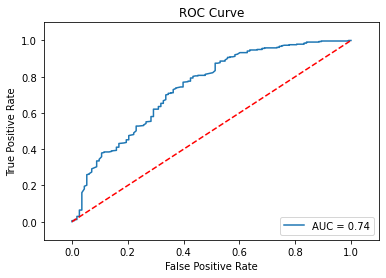

In [45]:
# Plotando a curva ROC
exibirCurvaROC(modeloClassificador, x_test, y_test)

### Modelo IC - Analisando outras Regiões

In [83]:
# Lista das Bases de Regiões
listaBases = ["Vacinas/Regioes/IC/ic-vacina-6040-centrooeste.xlsx", "Vacinas/Regioes/IC/ic-vacina-6040-sudeste.xlsx", 
               "Vacinas/Regioes/IC/ic-vacina-6040-norte.xlsx", "Vacinas/Regioes/IC/ic-vacina-6040-nordeste.xlsx"]

# Colunas Utilizadas
colunasSelecionadasTeste = ['faixaetaria', 'sexo', 'racaCor', 'dorDeGarganta', 'dispneia', 'coriza', 
                            'dorDeCabeca', 'diabetes', 'renal', 'imunossupressao', 'fragilidadeImuno', 
                            'gestante', 'cardiaca', 'qntVacinas']

alvo = 'evolucaoCaso'

In [84]:
alvos = [1, 2]
desempenhoDosModelos = pd.DataFrame()
for indice in range(0, len(listaBases)):
    covidData = pd.read_excel(listaBases[indice])
    dadosTeste = covidData.loc[:, colunasSelecionadasTeste]
    dadosAlvo =  covidData.loc[:, alvo]
     
    metricasMap = calcularMetricas(dadosTeste, dadosAlvo, listaBases[indice], modeloClassificador, alvos)
    desempenhoDosModelos = pd.concat([desempenhoDosModelos, pd.DataFrame([metricasMap])])
desempenhoDosModelos

,Acurácia,Base,Precisão (1),Recall (1),F1-Score (1),Precisão (2),Recall (2),F1-Score (2)
0,70.236%,Vacinas/Regioes/IC/ic-vacina-6040-centrooeste....,71.371%,97.387%,82.373%,26.923%,2.405%,4.416%
0,69.084%,Vacinas/Regioes/IC/ic-vacina-6040-sudeste.xlsx,71.223%,95.17%,81.474%,24.272%,3.87%,6.676%
0,71.107%,Vacinas/Regioes/IC/ic-vacina-6040-norte.xlsx,71.443%,99.177%,83.056%,33.333%,1.027%,1.993%
0,70.777%,Vacinas/Regioes/IC/ic-vacina-6040-nordeste.xlsx,71.372%,98.653%,82.824%,25.0%,1.122%,2.148%


In [ ]:
write = pd.ExcelWriter('desempenhoModeloICFinal.xlsx')
desempenhoDosModelos.to_excel(write, 'dados', index = False)
write.save()